### ライブラリのimport

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing.calculate_bmi_bmr_bsa_category import calculate_bmi_bmr_bsa_category
%matplotlib inline

## 解析用の元データを読み込み

In [26]:
df = pd.read_excel('preprocessed_train_data.xlsx')
df.head()

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,...,Mean CTDIvol,DLP,study_date,id,age,gender,height_cm,weight_kg,scan_area,scan_method
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,...,5.86,223.82,2021-01-01,12585,86,F,150.0,49.1,胸部CT,単純
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,...,7.41,327.55,2021-01-01,2145609,61,M,163.0,74.0,胸部CT,単純
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80,...,5.13,239.47,2021-01-02,12615,46,M,178.0,68.0,胸部CT,単純
3,1103327120210102,5.1 QQ Chest Routine,NaN,Chest,472.12,100,433.42,700,1.38,80,...,7.25,342.20,2021-01-02,12616,52,M,182.0,70.0,胸部CT,単純
4,1103481920210103,5.1 QQ Chest Routine,NaN,Chest,462.22,100,691.26,700,1.38,80,...,11.56,534.33,2021-01-03,9595120,52,M,175.0,112.0,胸部CT,単純


## 　新たな特徴量を作成

* BMI(Body Mass Index)  
  $BMI = weight(kg) / height(m)^2$  
  
* BMR(Basal Metabolic Rate: 基礎代謝率): 年齢、性別、身長、体重に基づいて計算される。ハリス・ベネディクト方程式と呼ばれる  
  男性$BMR=66.47 + (13.75*weight[kg]) + (5.003*height[cm]) - (6.755*age[歳])$  
  女性$BMR=655.1 + (9.563*weight[kg]) + (1.85*height[cm]) - (4.676*age[歳])$  
  
* 体格指数(Rohrer's index) ：学童期に適するとあるので、今回は使わない  
  $Rohrer's index = weight[kg] / height[m]^3$

体格指数（BMI）: 体重（kg）を身長（m）の二乗で割ったもので、以下のように分類されます（成人向けのWHOのガイドライン）。

18.5未満: 低体重（痩せ型）: underweight    
18.5～24.9: 標準体重: normal weight   
25.0～29.9: 肥満（1度）:obesity class1  
30.0～34.9: 肥満（2度）:obesity class2  
35.0～39.9: 肥満（3度）:obesity class3    
40以上: 肥満（4度、重症）:obesity class4

#### 体表面積を作成　　

体表面積 (m2
 )=0.007184×身長(cm) 
^0.725
 ×体重(kg)^
0.425

In [27]:
calculate_bmi_bmr_bsa_category(df)

In [28]:
df.head()

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,...,age,gender,height_cm,weight_kg,scan_area,scan_method,bmi,bmr,category_bmi,body_surface_area
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,...,86,F,150.0,49.1,胸部CT,単純,21.82,1000.01,normal weight,1.421484
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,...,61,M,163.0,74.0,胸部CT,単純,27.85,1487.40,obesity class1,1.797322
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80,...,46,M,178.0,68.0,胸部CT,単純,21.46,1581.27,normal weight,1.848150
3,1103327120210102,5.1 QQ Chest Routine,NaN,Chest,472.12,100,433.42,700,1.38,80,...,52,M,182.0,70.0,胸部CT,単純,21.13,1588.26,normal weight,1.901449
4,1103481920210103,5.1 QQ Chest Routine,NaN,Chest,462.22,100,691.26,700,1.38,80,...,52,M,175.0,112.0,胸部CT,単純,36.57,2130.73,obesity class3,2.256766


### 年代を追加

In [29]:
df['age_era'] = (df['age'] // 10) * 10

### scan_areaとscan_method(例：胸部CTx単純)をクロス集計

In [21]:
# クロス集計表の出現割合
cat_1 = 'scan_area'
cat_2 = 'scan_method'
X_cross = pd.crosstab(df[cat_1], df[cat_2], normalize='index')
X_cross = X_cross.reset_index()

# クロス集計表のテーブルへの変換
X_tbl = pd.melt(X_cross, id_vars=cat_1, value_name=f'rate_{cat_1} x {cat_2}')

# 出現割合の特徴量追加
df = pd.merge(df, X_tbl, on=[cat_1, cat_2], how='left')

### category_bmiとgenderのクロス集計

In [22]:
# クロス集計表の出現割合
cat_1 = 'category_bmi'
cat_2 = 'gender'
X_cross = pd.crosstab(df[cat_1], df[cat_2], normalize='index')
X_cross = X_cross.reset_index()

# クロス集計表のテーブルへの変換
X_tbl = pd.melt(X_cross, id_vars=cat_1, value_name=f'rate_{cat_1} x {cat_2}')

# 出現割合の特徴量追加
df = pd.merge(df, X_tbl, on=[cat_1, cat_2], how='left')

### category_bmiとage_eraのクロス集計

In [23]:
# クロス集計表の出現割合
cat_1 = 'age_era'
cat_2 = 'category_bmi'
X_cross = pd.crosstab(df[cat_1], df[cat_2], normalize='index')
X_cross = X_cross.reset_index()

# クロス集計表のテーブルへの変換
X_tbl = pd.melt(X_cross, id_vars=cat_1, value_name=f'rate_{cat_1} x {cat_2}')

# 出現割合の特徴量追加
df = pd.merge(df, X_tbl, on=[cat_1, cat_2], how='left')

In [24]:
df.head()

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,...,scan_area,scan_method,bmi,bmr,category_bmi,body_surface_area,age_era,rate_scan_area x scan_method,rate_category_bmi x gender,rate_age_era x category_bmi
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,...,胸部CT,単純,21.82,1000.01,normal weight,1.421484,80,0.973792,0.286558,0.642992
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,...,胸部CT,単純,27.85,1487.40,obesity class1,1.797322,60,0.973792,0.841565,0.262165
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80,...,胸部CT,単純,21.46,1581.27,normal weight,1.848150,40,0.973792,0.713442,0.620907
3,1103327120210102,5.1 QQ Chest Routine,NaN,Chest,472.12,100,433.42,700,1.38,80,...,胸部CT,単純,21.13,1588.26,normal weight,1.901449,50,0.973792,0.713442,0.509462
4,1103481920210103,5.1 QQ Chest Routine,NaN,Chest,462.22,100,691.26,700,1.38,80,...,胸部CT,単純,36.57,2130.73,obesity class3,2.256766,50,0.973792,0.718750,0.014442


### 各年代の性別ごとのBMIの中央値を作成し、それを新たな特徴量とする

In [94]:
median_bmi = df.groupby(['age_era', 'gender'])['bmi'].median().to_dict()

In [95]:
df['age_era_gender_bmi'] = df.apply(lambda row: median_bmi[row['age_era'], row['gender']], axis=1)

### 各年代の性別ごとのBMRの中央値を作成し、それを新たな特徴量とする 

In [96]:
median_bmr = df.groupby(['age_era', 'gender'])['bmr'].median().to_dict()
df['age_era_gender_bmr'] = df.apply(lambda row: median_bmr[row['age_era'], row['gender']], axis=1)

In [97]:
median_bsa = df.groupby(['age_era', 'gender'])['body_surface_area'].median().to_dict()
df['age_era_gender_bsa'] = df.apply(lambda row: median_bsa[row['age_era'], row['gender']], axis=1)

### 数値カラムに対する変換

* 身長は何かしら変換を加えて正規分布に近づけてみるのも良いかも(Box-Cox変換)
* age_era_gender_bmiとbody_surface_areもBox-Cox変換等の非線形処理をしても良い

### Clusterで分類、KMeansを使う

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


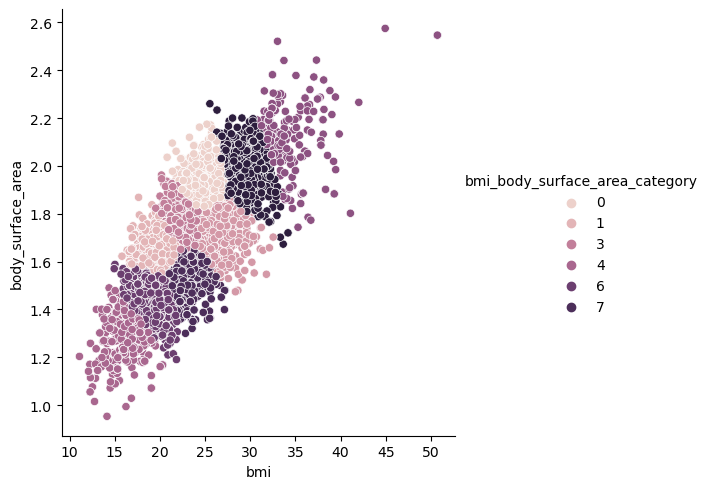

In [31]:
n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
sc = StandardScaler()

X = df.loc[:, ['bmi', 'body_surface_area']]
X_std = sc.fit_transform(X)

df['bmi_body_surface_area_category'] = kmeans.fit_predict(X_std)

sns.relplot(x='bmi', y='body_surface_area', hue='bmi_body_surface_area_category', data=df);

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


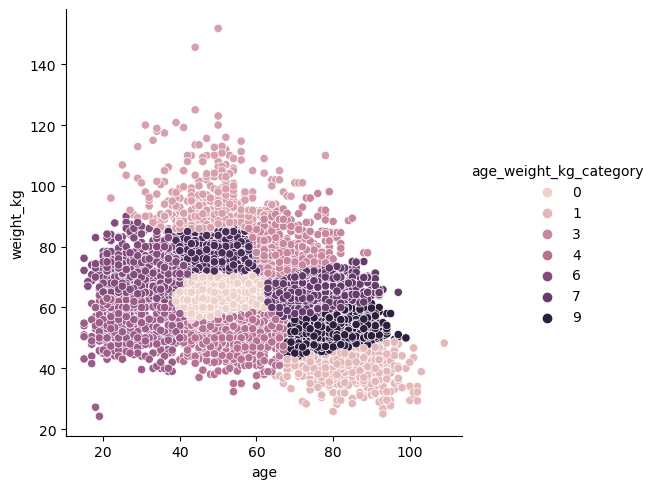

In [32]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
sc = StandardScaler()

X = df.loc[:, ['age', 'weight_kg']]
X_std = sc.fit_transform(X)

df['age_weight_kg_category'] = kmeans.fit_predict(X_std)

sns.relplot(x='age', y='weight_kg', hue='age_weight_kg_category', data=df);

In [33]:
#### scan_areaとscan_methodを組み合わせた特徴量を作成する

df['scan_area_method_combine'] = df['scan_area'] + '_' + df['scan_method']

#### scan_areaとscan_methodとscan_category_bmiを組み合わせた特徴量を作成する

df['scan_area_method_bmi_catgory_combine'] = df['scan_area'] + '_' + df['scan_method']  + '_' + df['category_bmi']

df['bmi_bsa_cat_scan_area_method_combine'] = df['bmi_body_surface_area_category'].astype(str) + df['scan_area_method_combine']

df['age_weight_cat_scan_area_method_combine'] = df['age_weight_kg_category'].astype(str) + df['scan_area_method_combine']

In [12]:
df.to_excel('modify_feature_engineer_train.xlsx', index=False)

In [84]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# 前処理をして相互情報量を計算
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder

te_columns = [ 'scan_area', 'category_bmi']
oe_columns = ['CTDIw phantom type','gender', 'scan_method']

oe = OrdinalEncoder()
oe.set_output(transform='pandas')

df[oe_columns] = oe.fit_transform(df[oe_columns])

te = TargetEncoder()
te.fit(df[te_columns], df['Mean CTDIvol'])
df[te_columns] = te.transform(df[te_columns])

df.drop(drops, axis=1)

drops = ['Mean CTDIvol', 'accession', 'scan protocol', 'target region', 'scan series', 
         'scanning length', 'kV', 'mean mA', 'max mA', 'pitch factor',
         'nomial total collimation width', 'exposure time per rotation',
         'exposure time', 'Mean CTDIvol', 'DLP', 'study_date', 'id']

target = 'Mean CTDIvol'
mi_scores = make_mi_scores(df.drop(drops, axis=1), df[target], 'auto')

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

ValueError: could not convert string to float: '胸部CT_単純'

In [34]:
df.head(3)

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,...,bmr,category_bmi,body_surface_area,age_era,bmi_body_surface_area_category,age_weight_kg_category,scan_area_method_combine,scan_area_method_bmi_catgory_combine,bmi_bsa_cat_scan_area_method_combine,age_weight_cat_scan_area_method_combine
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,...,1000.01,normal weight,1.421484,80,7,9,胸部CT_単純,胸部CT_単純_normal weight,7胸部CT_単純,9胸部CT_単純
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,...,1487.40,obesity class1,1.797322,60,2,3,胸部CT_単純,胸部CT_単純_obesity class1,2胸部CT_単純,3胸部CT_単純
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80,...,1581.27,normal weight,1.848150,40,3,0,胸部CT_単純,胸部CT_単純_normal weight,3胸部CT_単純,0胸部CT_単純


## クラスでまとめた部分

In [19]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from feature_engineering.dose_prediction_feature_engineering import FeatureEngineering
# from feature_engineering.predict_pitch_factor_rotation_time import PitchFactorClassifier, ExposureTimeRegressor
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
df = pd.read_excel('preprocessed_train_data.xlsx')
df.head()

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,...,Mean CTDIvol,DLP,study_date,id,age,gender,height_cm,weight_kg,scan_area,scan_method
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,...,5.86,223.82,2021-01-01,12585,86,F,150.0,49.1,胸部CT,単純
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,...,7.41,327.55,2021-01-01,2145609,61,M,163.0,74.0,胸部CT,単純
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80,...,5.13,239.47,2021-01-02,12615,46,M,178.0,68.0,胸部CT,単純
3,1103327120210102,5.1 QQ Chest Routine,NaN,Chest,472.12,100,433.42,700,1.38,80,...,7.25,342.20,2021-01-02,12616,52,M,182.0,70.0,胸部CT,単純
4,1103481920210103,5.1 QQ Chest Routine,NaN,Chest,462.22,100,691.26,700,1.38,80,...,11.56,534.33,2021-01-03,9595120,52,M,175.0,112.0,胸部CT,単純


In [15]:
fe = FeatureEngineering()

In [16]:
fe.fit(df)

In [22]:
df_train_transformed = fe.transform(df)

In [23]:
df_train_transformed.head(2)

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,...,body_surface_area,bmr,category_bmi,age_era,bmi_body_surface_area_category,age_weight_kg_category,scan_area_method_combine,scan_area_method_bmi_catgory_combine,bmi_bsa_cat_scan_area_method_combine,age_weight_cat_scan_area_method_combine
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,...,1.421484,1000.01,normal weight,80,8,8,胸部CT_単純,胸部CT_単純_normal weight,8胸部CT_単純,8胸部CT_単純
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,...,1.797322,1487.40,obesity class1,60,2,7,胸部CT_単純,胸部CT_単純_obesity class1,2胸部CT_単純,7胸部CT_単純


In [9]:
def replace_pitch_factor(df):
    if df['pitch factor'] == 0.99 or df['pitch factor'] == 0.98:
        return 1.0
    elif df['pitch factor'] == 0.52:
        return 0.51
    else:
        return df['pitch factor']



df['pitch factor'] = df.apply(replace_pitch_factor, axis=1)

df_chest = df[df['scan_area'] == '胸部CT']
df_chest_pelvis = df[df['scan_area'] == '胸部〜骨盤CT']
df_abd_pelvis = df[df['scan_area'] == '腹部〜骨盤CT']
df_inner = df[df['scan_area'] == '副鼻腔CT']
df_th_lw = df[df['scan_area'] == '胸腰椎CT']
df_leg = df[df['scan_area'] == '大腿・膝・下腿CT']
df_up_abd = df[df['scan_area'] == '上腹部CT']
df_dual = df[df['scan_area'] == '体幹部Dual Energy CT']
df_foot = df[df['scan_area'] == '足・足関節CT']
df_up_arm = df[df['scan_area'] == '肩・上腕・鎖骨CT']
df_neck_pelvis = df[df['scan_area'] == '頸部〜骨盤CT']
df_arm = df[df['scan_area'] == '肘・前腕・手関節CT']
df_cw = df[df['scan_area'] == '頸椎・頚髄CT']
df_neck = df[df['scan_area'] == '頸部CT']
df_pelvis_bone = df[df['scan_area'] == '骨盤骨CT']
df_face = df[df['scan_area'] == '顔面骨CT']
df_heart = df[df['scan_area'] == '冠動脈CT']
df_lung_vein = df[df['scan_area'] == '肺静脈CT']
df_lung = df[df['scan_area'] == '肺塞栓CT']
df_tooth = df[df['scan_area'] == '歯・顎骨CT']
df_perfusion = df[df['scan_area'] == '脳Perfusion']
df_brain_cta = df[df['scan_area'] == '脳CTA']
df_brain = df[df['scan_area'] == '脳CT']
df_side_bone = df[df['scan_area'] == '側頭骨CT']

df_list = [df_chest, df_chest_pelvis, df_abd_pelvis, df_inner,
           df_th_lw, df_leg, df_up_abd, df_dual, df_foot, df_up_arm,
           df_neck_pelvis, df_arm, df_cw, df_neck, df_pelvis_bone, df_face,
           df_heart, df_lung_vein, df_lung, df_tooth, df_perfusion, df_brain_cta,
           df_brain, df_side_bone]

In [10]:
from sklearn.tree import DecisionTreeRegressor

def classify_exposure_time_updated(df):
    """Classify exposure time per rotation using a decision tree model and return predictions for the entire dataset."""
    columns = ['bmi', 'body_surface_area']
    X = df.loc[:, columns]
    y = df['exposure time per rotation']
    y = y.astype('str')

    predictions = np.zeros(len(df), dtype=object)  # Ensure dtype is object for string predictions

    # Splitting and training the model
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    for fold, (tr_idx, va_idx) in enumerate(kf.split(X)):
        X_tr = X.iloc[tr_idx]
        X_va = X.iloc[va_idx]
        y_tr = y.iloc[tr_idx]
        y_va = y.iloc[va_idx]

        tree_model = DecisionTreeRegressor(criterion='absolute_error', max_depth=4, random_state=42)
        tree_model.fit(X_tr, y_tr)

        y_pred = tree_model.predict(X_va)
        predictions[va_idx] = y_pred

    return predictions

# Adding predicted exposure time to each dataframe in df_list using the updated function
for sub_df in df_list:
    sub_df['predicted_exposure_time'] = classify_exposure_time_updated(sub_df)

# Concatenating all dataframes in df_list to create one final dataframe
final_combined_df_exposure = pd.concat(df_list, axis=0)

final_combined_df_exposure.head()

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,...,bmr,category_bmi,age_era,bmi_body_surface_area_category,age_weight_kg_category,scan_area_method_combine,scan_area_method_bmi_catgory_combine,bmi_bsa_cat_scan_area_method_combine,age_weight_cat_scan_area_method_combine,predicted_exposure_time
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,...,1000.01,normal weight,80,8,8,胸部CT_単純,胸部CT_単純_normal weight,8胸部CT_単純,8胸部CT_単純,0.5
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,...,1487.40,obesity class1,60,2,7,胸部CT_単純,胸部CT_単純_obesity class1,2胸部CT_単純,7胸部CT_単純,0.5
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80,...,1581.27,normal weight,40,6,5,胸部CT_単純,胸部CT_単純_normal weight,6胸部CT_単純,5胸部CT_単純,0.5
3,1103327120210102,5.1 QQ Chest Routine,NaN,Chest,472.12,100,433.42,700,1.38,80,...,1588.26,normal weight,50,6,5,胸部CT_単純,胸部CT_単純_normal weight,6胸部CT_単純,5胸部CT_単純,0.5
4,1103481920210103,5.1 QQ Chest Routine,NaN,Chest,462.22,100,691.26,700,1.38,80,...,2130.73,obesity class3,50,4,2,胸部CT_単純,胸部CT_単純_obesity class3,4胸部CT_単純,2胸部CT_単純,0.5


In [11]:
def classify_pitch_factor_updated(df):
    """Classify pitch factor using a decision tree model and return predictions for the entire dataset."""
    columns = ['bmi', 'body_surface_area']
    X = df.loc[:, columns]
    y = df['pitch factor']
    y = y.astype('str')

    predictions = np.zeros(len(df))

    # Splitting and training the model
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    for fold, (tr_idx, va_idx) in enumerate(kf.split(X)):
        X_tr = X.iloc[tr_idx]
        X_va = X.iloc[va_idx]
        y_tr = y.iloc[tr_idx]
        y_va = y.iloc[va_idx]
        
        if len(y_tr.unique()) == 3:
            max_depth = 3
        else:
            max_depth = 2

        tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
        tree_model.fit(X_tr, y_tr)

        y_pred = tree_model.predict(X_va)
        predictions[va_idx] = y_pred

    return predictions

# Adding predicted pitch factor to each dataframe in df_list using the updated function
for sub_df in df_list:
    sub_df['predicted_pitch_factor'] = classify_pitch_factor_updated(sub_df)

# Concatenating all dataframes in df_list to create one final dataframe
final_combined_df = pd.concat(df_list, axis=0)

final_combined_df.head()

,accession,scan protocol,scan series,target region,scanning length,kV,mean mA,max mA,pitch factor,nomial total collimation width,...,category_bmi,age_era,bmi_body_surface_area_category,age_weight_kg_category,scan_area_method_combine,scan_area_method_bmi_catgory_combine,bmi_bsa_cat_scan_area_method_combine,age_weight_cat_scan_area_method_combine,predicted_exposure_time,predicted_pitch_factor
0,1103161420210101,5.1 QQ Chest Routine,NaN,Chest,382.14,100,350.24,640,1.38,80,...,normal weight,80,8,8,胸部CT_単純,胸部CT_単純_normal weight,8胸部CT_単純,8胸部CT_単純,0.5,1.38
1,1103161620210101,5.1 QQ Chest Routine,NaN,Chest,442.20,100,442.93,700,1.38,80,...,obesity class1,60,2,7,胸部CT_単純,胸部CT_単純_obesity class1,2胸部CT_単純,7胸部CT_単純,0.5,1.00
2,1103339220210102,5.1 QQ Chest Routine,NaN,Chest,467.06,100,306.59,700,1.38,80,...,normal weight,40,6,5,胸部CT_単純,胸部CT_単純_normal weight,6胸部CT_単純,5胸部CT_単純,0.5,1.38
3,1103327120210102,5.1 QQ Chest Routine,NaN,Chest,472.12,100,433.42,700,1.38,80,...,normal weight,50,6,5,胸部CT_単純,胸部CT_単純_normal weight,6胸部CT_単純,5胸部CT_単純,0.5,1.38
4,1103481920210103,5.1 QQ Chest Routine,NaN,Chest,462.22,100,691.26,700,1.38,80,...,obesity class3,50,4,2,胸部CT_単純,胸部CT_単純_obesity class3,4胸部CT_単純,2胸部CT_単純,0.5,0.51


In [13]:
final_combined_df.to_excel('modify_preprocess_train_data.xlsx', index=False)